In [1]:
import numpy as np
import matplotlib.pylab as plt
import scipy.stats as stats
import pymc3 as pm
import pandas as pd
import seaborn as sns
import arviz as az
from causalgraphicalmodels import CausalGraphicalModel

# Chapter 5 - The many variables & the spurious waffles

To start with I'll be reimplementing the figures to produce the plots. I'll be doing this the hard way, step by step for this chapter. Then, in the producing the plots for I'll be piggybacking on pymc3 to make everything more succinct, readable, and to speed up the general workflow. In general, everything will get much more readable with time!

## 5.1 Spurious association

### Multiple regression

In [2]:
data = pd.read_csv("./data/WaffleDivorce.csv",delimiter=";")# load waffle data

One can peform linear regressions. I reproduce fig 5.2 showing the Bayesian linear regressions between Marriage rate and divorce rate asa well as Median Marriage age and divorce rate

In [276]:
#scale all of the data
scaled_M = (data.Marriage - np.mean(data.Marriage))/np.std(data.Marriage)
scaled_A = (data.MedianAgeMarriage - np.mean(data.MedianAgeMarriage))/np.std(data.MedianAgeMarriage)
scaled_D = (data.Divorce - np.mean(data.Divorce))/np.std(data.Divorce)

In [4]:
#running a Marriage_divorce linear regression
with pm.Model() as Mar_Div:
    alpha = pm.Normal('alpha', mu=0, sd=0.2)#prior on alpha
    beta = pm.Normal("beta_M", mu=0,sd=0.5)#prior on beta
    sigma = pm.Exponential("sigma",lam = 1)#prior on sigma
    mu = alpha + beta * scaled_M
    Divorce = pm.Normal('Divorce', mu=mu, sd=sigma, observed=scaled_D)#likelihood of the data
    #print(mean_q)
    #Hess = pm.find_hessian(mean_q, vars=[alpha, beta,sigma])#find the hessian matrix
    Mar_Div_sample = pm.sample(draws= 250, chains = 4)#1000 random samples on 4 chains
    #get summary reports from the MCMC
    #pm.traceplot(sample)
pm.summary(Mar_Div_sample)

Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_M, alpha]


Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 9 seconds.
/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-0.003,0.118,-0.230,0.194,0.004,0.004,1077.0,479.0,1081.0,771.0,1.00
beta_M,0.352,0.132,0.126,0.622,0.004,0.003,1234.0,1204.0,1244.0,590.0,1.00
sigma,0.964,0.100,0.790,1.149,0.003,0.002,1147.0,1104.0,1179.0,778.0,1.01


In [5]:
#running a Age_divorce linear regression
with pm.Model() as Age_Div:
    alpha = pm.Normal('alpha', mu=0, sd=0.2)#prior on alpha
    beta = pm.Normal("beta_A", mu=0,sd=0.5)#prior on beta
    sigma = pm.Exponential("sigma",lam = 1)#prior on sigma
    mu = alpha + beta * scaled_A
    Divorce = pm.Normal('Divorce', mu=mu, sd=sigma, observed=scaled_D)#likelihood of the data
    #print(mean_q)
    #Hess = pm.find_hessian(mean_q, vars=[alpha, beta,sigma])#find the hessian matrix
    Age_Div_sample = pm.sample(draws= 250, chains = 4)#1000 random samples on 4 chains
    #get summary reports from the MCMC
    #pm.traceplot(sample)
pm.summary(Age_Div_sample)

Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_A, alpha]


Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 3 seconds.
The acceptance probability does not match the target. It is 0.8851676387227548, but should be close to 0.8. Try to increase the number of tuning steps.
/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-0.003,0.102,-0.184,0.189,0.003,0.003,1318.0,477.0,1305.0,785.0,1.0
beta_A,-0.564,0.112,-0.769,-0.364,0.003,0.002,1407.0,1359.0,1412.0,868.0,1.0
sigma,0.831,0.084,0.670,0.984,0.002,0.002,1204.0,1154.0,1243.0,653.0,1.0


In [8]:
#sample the posterior for a range of x values, for both models
x1 = np.linspace(np.min(scaled_M),np.max(scaled_M))
Mar_Div_post_samples = Mar_Div_sample["alpha"] + np.outer(x1,Mar_Div_sample["beta_M"])
x2 = np.linspace(np.min(scaled_A),np.max(scaled_A))
Age_Div_post_samples = Age_Div_sample["alpha"] + np.outer(x2,Age_Div_sample["beta_A"])

In [9]:
#get the unscaled x coords
unscaled_x1 = x1*np.std(data.Marriage) + np.mean(data.Marriage)
means1 = np.mean(Mar_Div_post_samples,axis=1)*np.std(data.Divorce) + np.mean(data.Divorce)#get the means
Lower1 = np.quantile(Mar_Div_post_samples,0.055,axis=1)*np.std(data.Divorce) + np.mean(data.Divorce)#get the lower interval
Upper1 = np.quantile(Mar_Div_post_samples,0.945,axis=1)*np.std(data.Divorce) + np.mean(data.Divorce)#get the lower interval
unscaled_x2 = x2*np.std(data.MedianAgeMarriage) + np.mean(data.MedianAgeMarriage)
means2 = np.mean(Age_Div_post_samples,axis=1)*np.std(data.Divorce) + np.mean(data.Divorce)
Lower2 = np.quantile(Age_Div_post_samples,0.055,axis=1)*np.std(data.Divorce) + np.mean(data.Divorce)#get the lower interval
Upper2 = np.quantile(Age_Div_post_samples,0.945,axis=1)*np.std(data.Divorce) + np.mean(data.Divorce)#get the lower interva

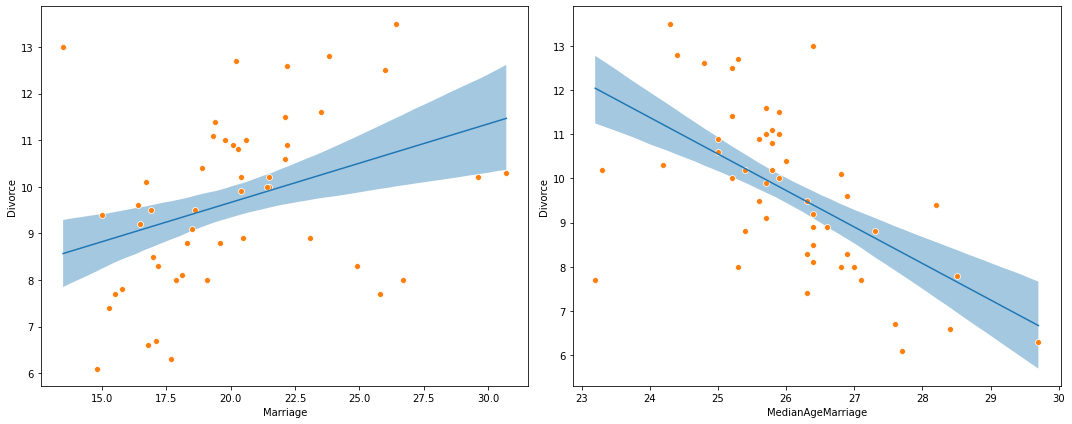

In [10]:
fig, axs = plt.subplots(1,2,figsize=(15,6))
axs[0].plot(unscaled_x1, means1)
axs[0].fill_between(unscaled_x1,Lower1,Upper1,alpha=0.4)
sns.scatterplot(x="Marriage", y="Divorce", data=data, ax=axs[0])
axs[1].plot(unscaled_x2, means2)
axs[1].fill_between(unscaled_x2,Lower2,Upper2,alpha=0.4)
sns.scatterplot(x="MedianAgeMarriage", y="Divorce", data=data, ax=axs[1])
fig.tight_layout()

We see the pair wise associations exist between these variables. We can now fit the multivariate linear regression model.

In [196]:
#running a Mar+Age_divorce linear regression
with pm.Model() as Mar_Age_Div:
    alpha = pm.Normal('alpha', mu=0, sd=0.2)#prior on alpha
    beta_M = pm.Normal("beta_M", mu=0,sd=0.5)#prior on beta_M
    beta_A = pm.Normal("beta_A", mu=0,sd=0.5)#prior on beta_A
    sigma = pm.Exponential("sigma",lam = 1)#prior on sigma
    mu = alpha + beta_A * scaled_A + beta_M * scaled_M
    Divorce = pm.Normal('Divorce', mu=mu, sd=sigma, observed=scaled_D)#likelihood of the data
    #print(mean_q)
    #Hess = pm.find_hessian(mean_q, vars=[alpha, beta,sigma])#find the hessian matrix
    Mar_Age_Div_sample = pm.sample(draws= 250, chains = 4)#1000 random samples on 4 chains
    #get summary reports from the MCMC
    #pm.traceplot(sample)
pm.summary(Mar_Age_Div_sample)

Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_A, beta_M, alpha]


Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 2 seconds.
/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-0.004,0.109,-0.216,0.194,0.004,0.003,844.0,559.0,844.0,768.0,1.00
beta_M,-0.054,0.150,-0.334,0.222,0.006,0.004,558.0,558.0,574.0,646.0,1.01
beta_A,-0.599,0.152,-0.864,-0.299,0.006,0.004,631.0,631.0,638.0,786.0,1.00
sigma,0.838,0.092,0.677,1.014,0.003,0.002,792.0,784.0,806.0,689.0,1.00


/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


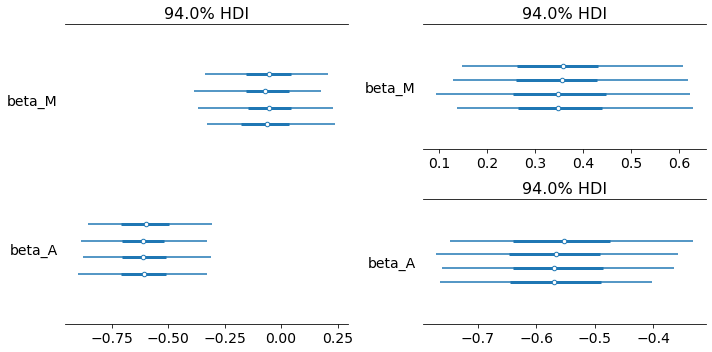

In [149]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(10,5))
gs = gridspec.GridSpec(2, 2) # 2x2 grid
ax0 = fig.add_subplot(gs[:, 0]) # first row, first col
ax1 = fig.add_subplot(gs[0, 1]) # first row, second col
ax2 = fig.add_subplot(gs[1, 1]) # full second row
ax0.set_title("Multivariate")
ax1.set_title("Univariate")
pm.forestplot(Mar_Age_Div_sample,var_names=["beta_M","beta_A"],ax=ax0)
pm.forestplot(Mar_Div_sample,var_names=["beta_M"],ax=ax1)
pm.forestplot(Age_Div_sample,var_names=["beta_A"],ax=ax2)
fig.tight_layout()

Comparing the mulitvariate parameters to the univariate regressions on the right, we can see that the estimates of $\beta_M$ go to zero when Age is accounted for.

### Plotting Multivariate posteriors

I reproduce the predictor residual plots of the data. First we have to perform the regression of Marriage rate on Age at marriage, then the other way around.

In [57]:
#predict Marriage
#running a Age -> Mar linear regression
with pm.Model() as Age_pred_marriage:
    alpha = pm.Normal('alpha', mu=0, sd=0.2)#prior on alpha
    beta_A = pm.Normal("beta_A", mu=0,sd=0.5)#prior on beta_A
    sigma = pm.Exponential("sigma",lam = 1)#prior on sigma
    mu = pm.Deterministic("mu",alpha + beta_A * scaled_A)
    Marriage = pm.Normal('Marriage', mu=mu, sd=sigma, observed=scaled_M)#likelihood of the data
    Age_2_Mar_sample = pm.sample(draws= 250, chains = 4)#1000 random samples on 4 chains
    #get summary reports from the MCMC
    #pm.traceplot(sample)

#predict age
#running a Mar -> Age linear regression
with pm.Model() as Age_pred_marriage:
    alpha = pm.Normal('alpha', mu=0, sd=0.2)#prior on alpha
    beta_M = pm.Normal("beta_M", mu=0,sd=0.5)#prior on beta_M
    sigma = pm.Exponential("sigma",lam = 1)#prior on sigma
    mu = pm.Deterministic("mu",alpha + beta_M * scaled_M)
    Age = pm.Normal('Marriage', mu=mu, sd=sigma, observed=scaled_A)#likelihood of the data
    Mar_2_Age_sample = pm.sample(draws= 250, chains = 4)#1000 random samples on 4 chains
    #get summary reports from the MCMC
    #pm.traceplot(sample)

Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_A, alpha]


Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 2 seconds.
Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_M, alpha]


Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 2 seconds.
The acceptance probability does not match the target. It is 0.8786146330321501, but should be close to 0.8. Try to increase the number of tuning steps.


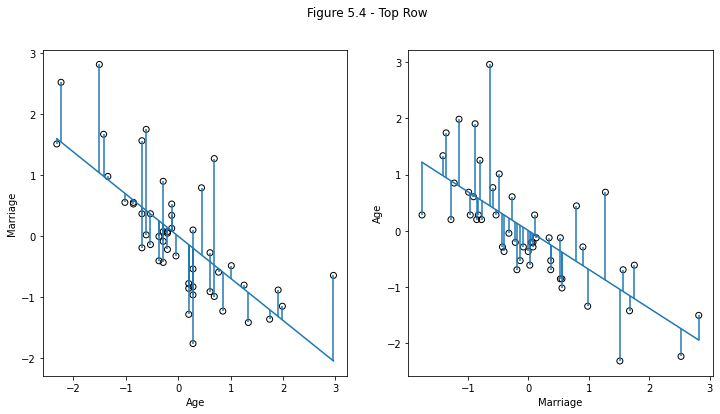

In [150]:
x0 = np.linspace(np.min(scaled_A),np.max(scaled_A))
def pred0(x): return np.mean(Age_2_Mar_sample["alpha"]) +  x*np.mean(Age_2_Mar_sample["beta_A"])
x1 =  np.linspace(np.min(scaled_M),np.max(scaled_M))
def pred1(x): return np.mean(Mar_2_Age_sample["alpha"]) +  x*np.mean(Mar_2_Age_sample["beta_M"])

#plot the figure
fig, axs = plt.subplots(1,2,figsize = (12,6))
fig.suptitle("Figure 5.4 - Top Row")

axs[0].scatter(scaled_A,scaled_M, facecolors="none", edgecolors="black")
axs[0].plot(x0, pred0(x0))
axs[0].set_xlabel("Age")
axs[0].set_ylabel("Marriage")
resids0 = scaled_M - pred0(scaled_A)
axs[0].vlines(scaled_A,pred0(scaled_A), pred0(scaled_A) + resids0)

axs[1].scatter(scaled_M,scaled_A, facecolors="none", edgecolors="black")
axs[1].plot(x1, pred1(x1))
axs[1].set_xlabel("Marriage")
axs[1].set_ylabel("Age")
resids1 = scaled_A - pred1(scaled_M)
axs[1].vlines(scaled_M,pred1(scaled_M), pred1(scaled_M) + resids1,)
plt.show()

Now we regress the residuals against divorce

In [151]:
#predict Divorce
#running a Mar_resid -> divorce linear regression
with pm.Model() as Mar_resids:
    alpha = pm.Normal('alpha', mu=0, sd=0.2)#prior on alpha
    beta = pm.Normal("beta", mu=0,sd=0.5)#prior on beta
    sigma = pm.Exponential("sigma",lam = 1)#prior on sigma
    mu = pm.Deterministic("mu",alpha + beta * resids0)
    Divorce = pm.Normal('Divorce', mu=mu, sd=sigma, observed=scaled_D)#likelihood of the data
    Mar_res_sample = pm.sample(draws= 500, chains = 4)#1000 random samples on 4 chains
    #get summary reports from the MCMC
    #pm.traceplot(sample)

#predict age
#running a Age_resid -> divorce linear regression
with pm.Model() as Age_resids:
    alpha = pm.Normal('alpha', mu=0, sd=0.2)#prior on alpha
    beta = pm.Normal("beta", mu=0,sd=0.5)#prior on beta
    sigma = pm.Exponential("sigma",lam = 1)#prior on sigma
    mu = pm.Deterministic("mu",alpha + beta * resids1)
    Divorce = pm.Normal('Divorce', mu=mu, sd=sigma, observed=scaled_D)#likelihood of the data
    Age_res_sample = pm.sample(draws= 500, chains = 4)#1000 random samples on 4 chains
    #get summary reports from the MCMC
    #pm.traceplot(sample)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 2 seconds.


/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)
/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)
/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


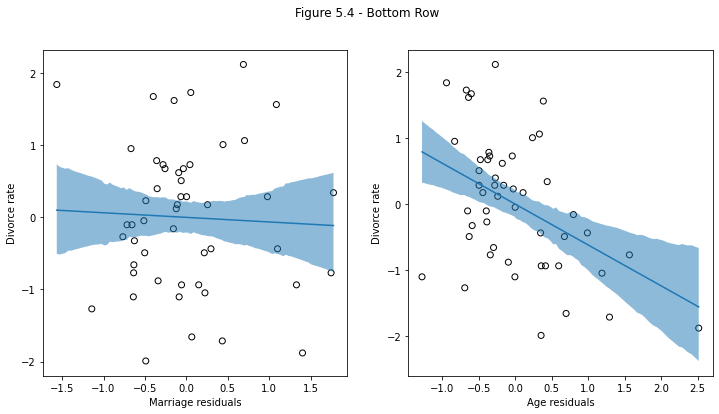

In [152]:
#plot the residual predictor plots
x0 = np.linspace(np.min(resids0),np.max(resids0),100)
x1 =  np.linspace(np.min(resids1),np.max(resids1),100)

#plot the figure
#get the posterior distibution of lines
vals0 = Mar_res_sample["alpha"] +  np.outer(x0,Mar_res_sample["beta"])
vals1 = Age_res_sample["alpha"] +  np.outer(x1,Age_res_sample["beta"])
#get the intervals on the posterior


fig, axs = plt.subplots(1,2,figsize = (12,6))
fig.suptitle("Figure 5.4 - Bottom Row")


axs[0].scatter(resids0,scaled_D, facecolors="none", edgecolors="black")
axs[0].plot(x0, np.mean(vals0,axis=1))
axs[0].set_xlabel("Marriage residuals")
axs[0].set_ylabel("Divorce rate")
axs[0].fill_between(x0, pm.hpd(vals0.T)[:,0],pm.hpd(vals0.T)[:,1],alpha=0.5 )

axs[1].scatter(resids1,scaled_D, facecolors="none", edgecolors="black")
axs[1].plot(x1, np.mean(vals1,axis=1))
axs[1].set_xlabel("Age residuals")
axs[1].set_ylabel("Divorce rate")
axs[1].fill_between(x1, pm.hpd(vals1.T)[:,0],pm.hpd(vals1.T)[:,1],alpha = 0.5 )

### Posterior prediction plots

In [153]:
#get the posterior parameters for each value in data
post_mu = Mar_Age_Div_sample["alpha"] + np.outer(scaled_A,Mar_Age_Div_sample["beta_A"])  + np.outer(scaled_M,Mar_Age_Div_sample["beta_M"])
post_sigma = np.repeat(Mar_Age_Div_sample["sigma"],repeats=(50)).reshape(-1,50).T

In [156]:
#sample the likelihood with posterior parameters
post_preds= np.random.normal(loc = post_mu, scale = post_sigma )

/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)
/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


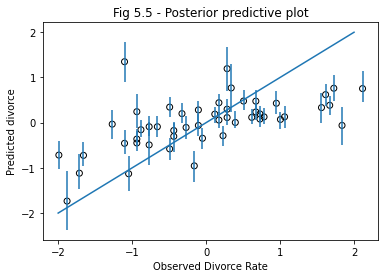

In [171]:
plt.vlines(scaled_D, pm.hpd(post_mu.T,hdi_prob=0.89)[:,0],pm.hpd(post_mu.T,hdi_prob=0.89)[:,1])
plt.scatter(scaled_D, np.mean(post_preds,axis=1), facecolors="None",edgecolors="black")
plt.plot(np.linspace(-2,2),np.linspace(-2,2))
plt.xlabel("Observed Divorce Rate")
plt.ylabel("Predicted divorce")
plt.title("Fig 5.5 - Posterior predictive plot")
plt.show()

### Counterfactual plots

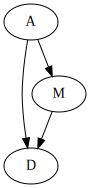

In [1]:
from causalgraphicalmodels import CausalGraphicalModel

MarriageDag = CausalGraphicalModel(
    nodes=["A","M","D"],
    edges=[
        ("A","M"),
        ("A", "D"),
        ("M","D")
    ]
)

# draw return a graphviz `dot` object, which jupyter can render
MarriageDag.draw()

We can produce the counterfactual counterfactual plots impact of increasing age for this DAG. I already have the A -> M association posteriors from the earlier model, as well as the A -> D <- M

/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)
/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)
/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


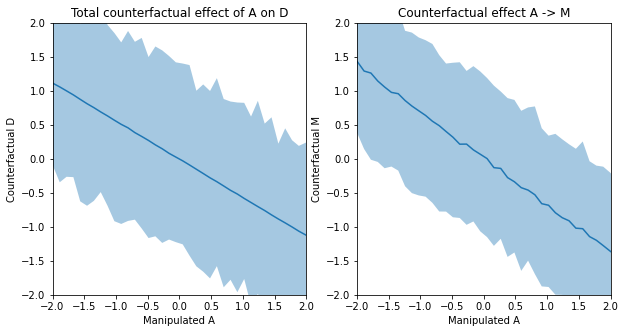

In [229]:
fig, axs = plt.subplots(1,2,figsize=(10,5))

#A -> M counterfactual plots
xA = np.linspace(np.min(scaled_A),np.max(scaled_A))
post_mu = Age_2_Mar_sample["alpha"] + np.outer(xA,Age_2_Mar_sample["beta_A"])
post_sig = np.repeat(Age_2_Mar_sample["sigma"],50).reshape(-1,50).T
post_sample = np.random.normal(post_mu,post_sig)#random sample from likelihood
axs[1].plot(xA, np.mean(post_sample,axis=1))
axs[1].fill_between(xA, pm.hpd(post_sample.T,hdi_prob=0.89)[:,0],pm.hpd(post_sample.T,hdi_prob=0.89)[:,1], alpha = 0.4)
axs[1].set_title("Counterfactual effect A -> M")
axs[1].set_xlabel("Manipulated A")
axs[1].set_ylabel("Counterfactual M")
axs[1].set_xlim(-2,2)
axs[1].set_ylim(-2,2)
#Full A -> D counterfactual
#Now get the D counterfactuals
D_mu = Mar_Age_Div_sample["alpha"] + np.outer(xA,Mar_Age_Div_sample["beta_A"]) + post_sample * Mar_Age_Div_sample["beta_M"]
post_sample = np.random.normal(D_mu,Mar_Age_Div_sample["sigma"])
axs[0].plot(xA, np.mean(CounterD,axis=1))
axs[0].fill_between(xA, pm.hpd(post_sample.T,hdi_prob=0.89)[:,0],pm.hpd(post_sample.T,hdi_prob=0.89)[:,1], alpha = 0.4)
axs[0].set_title("Total counterfactual effect of A on D")
axs[0].set_xlabel("Manipulated A")
axs[0].set_ylabel("Counterfactual D")
axs[0].set_xlim(-2,2)
axs[0].set_ylim(-2,2)
plt.show()


### 5.2 Masked Relationships

In [233]:
milk = pd.read_csv("./data/milk.csv",delimiter=";")
#drop the nans
milk = milk[~np.isnan(milk["neocortex.perc"])]

In [231]:
#add functions to perform scaling of variables
def standardise(series): return (series - series.mean()) / series.std()


In [237]:
#scale the relevant data.
scaled_M, scaled_N, scaled_K = standardise(milk["mass"]), standardise(milk["neocortex.perc"]), standardise(milk["kcal.per.g"])

In [258]:
with pm.Model() as Milk_model_wide_prior:
    alpha = pm.Normal("alpha", 0.0, 1) #set alpha prior
    beta_N = pm.Normal("beta_N", 0.0, 1) #set beta prior 
    mu = alpha + beta_N * scaled_N
    sigma = pm.Exponential("sigma", 1.0)
    obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=scaled_K)
    prior_checks_wide_prior = pm.sample_prior_predictive(samples=50, random_seed=42)

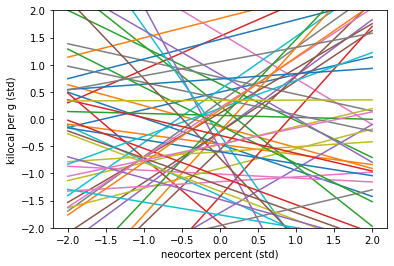

In [259]:
x = np.linspace(-2,2)
for alpha, beta in zip(prior_checks_wide_prior["alpha"],prior_checks_wide_prior["beta_N"]):
    y = alpha + beta * x
    plt.plot(x,y)
plt.ylim(-2,2)
plt.xlabel("neocortex percent (std)")
plt.ylabel("kilocal per g (std)")
plt.show()

This is with crazy loose values on the priors. We can tighten them up to give more sensible relationships.

In [254]:
with pm.Model() as Milk_model_narrow_prior:
    alpha = pm.Normal("alpha", 0.0, 0.2) #set alpha prior
    beta_N = pm.Normal("beta_N", 0.0, 0.5) #set beta prior 
    mu = alpha + beta_N * scaled_N
    sigma = pm.Exponential("sigma", 1.0)
    obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=scaled_K)
    prior_checks_narrow_prior = pm.sample_prior_predictive(samples=50, random_seed=42)


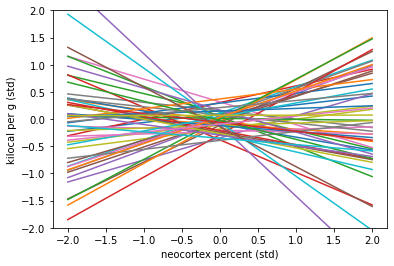

In [262]:
x = np.linspace(-2,2)
for alpha, beta in zip(prior_checks_narrow_prior["alpha"],prior_checks_narrow_prior["beta_N"]):
    y = alpha + beta * x
    plt.plot(x,y)
plt.ylim(-2,2)
plt.xlabel("neocortex percent (std)")
plt.ylabel("kilocal per g (std)")
plt.show()

We can now fit a model that uses both Mass and Neocortex as predictors of milk caloric content of a given species. We will actually be using log_mass as a predictor

In [266]:
milk["log_mass"] = np.log(milk["mass"])
scaled_LM = standardise(milk["log_mass"])

<ipython-input-266-f73c83d4ca76>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  milk["log_mass"] = np.log(milk["mass"])


In [305]:
#log mass to predict kcal
with pm.Model() as log_mass_2_kcal:
    alpha = pm.Normal("alpha", 0,0.2)
    beta_M = pm.Normal("beta_M",0,0.5)
    mu = alpha + beta_M * scaled_LM
    sigma = pm.Exponential("Sigma", 1)
    K = pm.Normal("K", mu,sigma, observed = scaled_K)
    post_sample_log_mass = pm.sample(draws = 1000,chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Sigma, beta_M, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [288]:
with Milk_model_narrow_prior:
    post_sample_Neo = pm.sample(draws = 1000,chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_N, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [311]:
#log mass and neocortex to predict kcal
with pm.Model() as log_mass_neo_2_kcal:
    alpha = pm.Normal("alpha", 0,0.2)
    beta_M = pm.Normal("beta_M",0,0.5)
    beta_N = pm.Normal("beta_N",0,0.5)
    mu = alpha + beta_M * scaled_LM + beta_N * scaled_N
    sigma = pm.Exponential("Sigma", 1)
    K = pm.Normal("K", mu,sigma, observed = scaled_K)
    post_sample_log_mass_neo = pm.sample(draws = 1000,chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Sigma, beta_N, beta_M, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)
/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)
/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packag

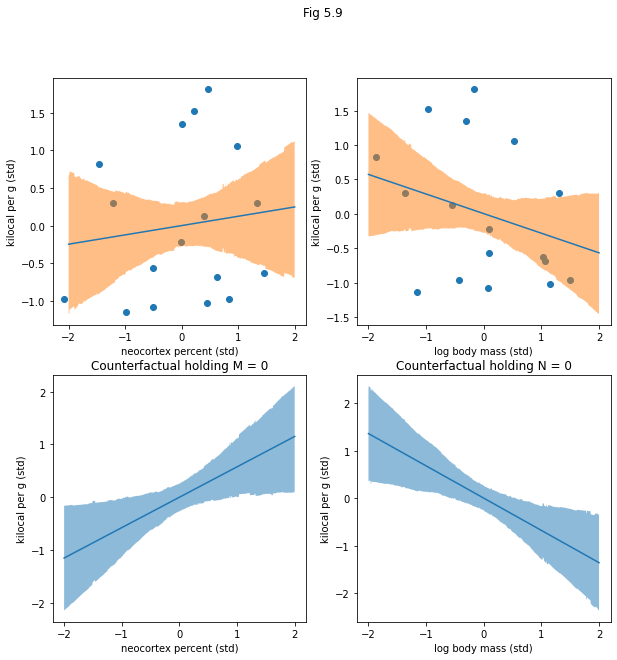

In [322]:
fig, axs = plt.subplots(2,2,figsize=(10,10))
fig.suptitle("Fig 5.9")

x = np.linspace(-2,2,1000)
line0 = post_sample_Neo["alpha"] + np.outer(x, post_sample_Neo["beta_N"])
line1 = post_sample_log_mass["alpha"] + np.outer(x, post_sample_log_mass["beta_M"])                                    

axs[0,0].scatter(scaled_N,scaled_K)
axs[0,0].plot(x, np.mean(line0,axis=1))
axs[0,0].fill_between(x, pm.hpd(line0.T)[:,0],pm.hpd(line0.T)[:,1],alpha = 0.5)
axs[0,0].set_xlabel("neocortex percent (std)")
axs[0,0].set_ylabel("kilocal per g (std)")

axs[0,1].scatter(scaled_LM,scaled_K)
axs[0,1].plot(x, np.mean(line1,axis=1))
axs[0,1].fill_between(x, pm.hpd(line1.T)[:,0],pm.hpd(line1.T)[:,1],alpha = 0.5)
axs[0,1].set_xlabel("log body mass (std)")
axs[0,1].set_ylabel("kilocal per g (std)")

K_pred = post_sample_log_mass_neo["alpha"] + np.outer(x,post_sample_log_mass_neo["beta_N"])
axs[1,0].plot(x,np.mean(K_pred,axis=1))
axs[1,0].fill_between(x, pm.hpd(K_pred.T)[:,0],pm.hpd(K_pred.T)[:,1], alpha = 0.5)
axs[1,0].set_title("Counterfactual holding M = 0")
axs[1,0].set_xlabel("neocortex percent (std)")
axs[1,0].set_ylabel("kilocal per g (std)")


K_pred = post_sample_log_mass_neo["alpha"] + np.outer(x,post_sample_log_mass_neo["beta_M"])
axs[1,1].plot(x,np.mean(K_pred,axis=1))
axs[1,1].fill_between(x, pm.hpd(K_pred.T)[:,0],pm.hpd(K_pred.T)[:,1], alpha = 0.5)
axs[1,1].set_title("Counterfactual holding N = 0")
axs[1,1].set_xlabel("log body mass (std)")
axs[1,1].set_ylabel("kilocal per g (std)")

plt.show()

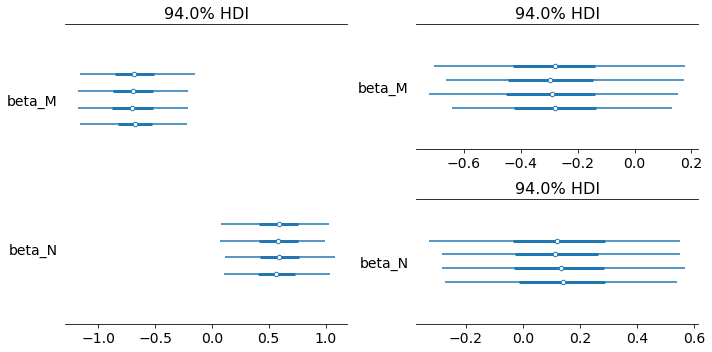

In [324]:
fig = plt.figure(figsize=(10,5))
gs = gridspec.GridSpec(2, 2) # 2x2 grid
ax0 = fig.add_subplot(gs[:, 0]) # first row, first col
ax1 = fig.add_subplot(gs[0, 1]) # first row, second col
ax2 = fig.add_subplot(gs[1, 1]) # full second row
ax0.set_title("Multivariate")
ax1.set_title("Univariate")
pm.forestplot(post_sample_log_mass_neo,var_names=["beta_M","beta_N"],ax=ax0)
pm.forestplot(post_sample_log_mass,var_names=["beta_M"],ax=ax1)
pm.forestplot(post_sample_Neo,var_names=["beta_N"],ax=ax2)
fig.tight_layout()

One can see that the predictive power of both mass and neo cortex become larger in magnitude when both effects are accounted for (on the left), then when they are accounted for separately (right). This is due to the masked relationship being uncovered, where one predictor variable drives down the value of another.

### 5.3 Categorical variables

This sections seemed so self evident that I don't take the time to reimplement it here

## End of Chapter Problems

In making my implementations and problem solutions for this chapter I will be making use of the "causalgraphicalmodels" package. This allows for straight forward visualisations of the DAGs.

5E1. Which of the linear models below are multiple linear regressions?

(1) µi = α + βxi

(2) µi = $β_x$xi + $β_z$zi

(3) µi = α + β(xi − zi)

(4) µi = α + $β_x$xi + $β_z$zi

Answer: 2) & 4) & 3)?. Answer 1 only contains a single variable and answer 3 sums is multiple regression where the coefficient of xi and zi are constrained to be equal. This seems unusual to me, but I see it as a form of contrained multiple regression.

5E2. Write down a multiple regression to evaluate the claim: Animal diversity is linearly related to latitude, but only after controlling for plant diversity. You just need to write down the model definition.

Answer: $Ad_i = \alpha + \beta_{L} L_i  + \beta_{Pd} Pd$

where Ad and Pd mean animal diversity and plant diversity respectively, and L denotes Latitude.

5E3. Write down a multiple regression to evaluate the claim: Neither amount of funding nor size of laboratory is by itself a good predictor of time to PhD degree; but together these variables are both positively associated with time to degree. Write down the model definition and indicate which side of zero each slope parameter should be on.

Answer: Letting F denote funding and S denote laboratory size, then the model is that 
$T_i = \alpha + \beta_f F_i + \beta_s S_i$

and the claim is that both $\beta_f \& \beta_s$ are positively associated with time to degree.

5E4. Suppose you have a single categorical predictor with 4 levels (unique values), labeled A, B, C
and D. Let Ai be an indicator variable that is 1 where case i is in category A. Also suppose Bi, Ci, and Di for the other categories. Now which of the following linear models are inferentially equivalent 
ways to include the categorical variable in a regression? Models are inferentially equivalent when it’s possible to compute one posterior distribution from the posterior distribution of another model.

(1) µi = α + $β_A$Ai + $β_B$Bi + $β_D$Di

(2) µi = α + $β_A$Ai + $β_B$Bi + $β_C$Ci + $β_D$Di

(3) µi = α + $β_B$Bi + $β_C$Ci + $β_D$Di

(4) µi = $α_A$Ai + $α_B$Bi + $α_C$Ci + $α_D$Di

(5) µi = $α_A$(1 − $B_i$ − $C_i$ − $D_i$) + $α_B$Bi + $α_C$Ci + $α_D$Di

Answer: Models 1,3,4,5 are equivalent. As A,B,C,D are all values of the same variable, for any given case i, this implies that only one of the indicator variables in the above expressions can equal one for any given instance. This in turn implies that eq.1 is equivalent to eq.4. Why? Inspeceting eq.1, if instance i is in category c, the $\mu_i = \alpha$. For eq.4, $\mu_i = \alpha_c$. Similarly $\mu_i$ will equal $\beta_c$ and $\alpha_c$ in equations 2 and 5 respectively. Eq's 1,3,4,5 all have 4 parameters within them, that can be uniquely transformed into the parameters of the other equations. Eq.2 however contains an additional parameter, the intercept, which cannot be obtained uniquely from the parameters.



5M1. Invent your own example of a spurious correlation. An outcome variable should be correlated with both predictor variables. But when both predictors are entered in the same model, the correlation between the outcome and one of the predictors should mostly vanish (or at least be greatly reduced).

Answer: Let's consider an example, which I have no idea whether it's true or not. Let's take parental IQ, Parental income and childrens IQ. Let's imagine a world where parental IQ causes both child's IQ and parents income, but the parent's income has absolutely no causal effect on a child's IQ. See the causal diagram below. Again, I'm not really claiming this is true, it's just a concievable toy model. In this world, the correlation between a child's IQ and parental income would be completely spurious, both actually being caused by the parent's IQ. One could imagine that parents with higher IQs are both able to get better incomes and they are also able to increase their childs IQ either through heritability, or because parents with higher IQs are able to give their children better environments. I'm agnostic about what is true in the real world. I'm just making a toy model.

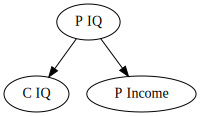

In [2]:
from causalgraphicalmodels import CausalGraphicalModel

sprinkler = CausalGraphicalModel(
    nodes=["P IQ", "C IQ", "P Income"],
    edges=[
        ("P IQ", "P Income"),
        ("P IQ", "C IQ")
    ]
)

# draw return a graphviz `dot` object, which jupyter can render
sprinkler.draw()

In [3]:
#synthesis fake data representing this model
PIQ = np.random.normal(loc=100,scale=15,size =100) #set the parental IQ
PIN = np.random.normal(loc=PIQ*100 +70000, scale = 2000) #set parental annual income
CIQ = np.random.normal(loc=PIQ, scale =7.5) # set child IQ as being determined by parental IQ

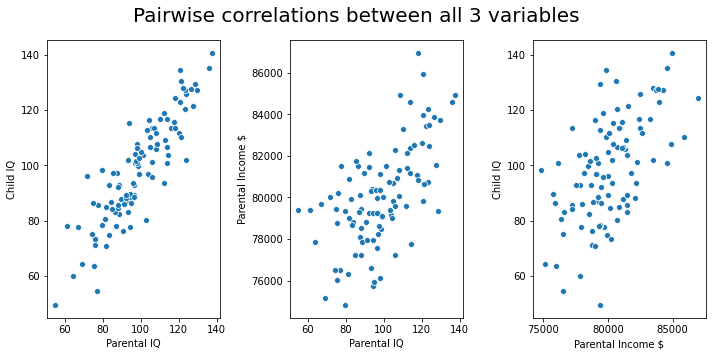

In [4]:
fig,axs = plt.subplots(1,3,figsize=(10,5))
fig.suptitle("Pairwise correlations between all 3 variables", fontsize=20)
sns.scatterplot(PIQ,CIQ,ax=axs[0])
axs[0].set_xlabel("Parental IQ")
axs[0].set_ylabel("Child IQ")
sns.scatterplot(PIQ,PIN,ax=axs[1])
axs[1].set_xlabel("Parental IQ")
axs[1].set_ylabel("Parental Income $")
sns.scatterplot(PIN,CIQ,ax=axs[2])
axs[2].set_xlabel("Parental Income $")
axs[2].set_ylabel("Child IQ")
plt.tight_layout()

We can now perform our linear regressions on these models. I'll just use pymc3 MCMC tool to estimate this and not bother with Laplace's method for now. I'll fit two linear models to the data, both of which will attempt to predict child IQ. The first model will use just parental income and the second will make use of both parental income and parental IQ. As I generated this data in such a way as for the parental income to be spurious, we should see the first model have a positive slope parameter and the second model should have zero slope parameter for the parental income variable. More formally

### Model 1



$CIQ_i$ ~ $N(\mu_i,\sigma^2)$

$\mu_i = \alpha + \beta(x_i - \bar{x})$

$\alpha$ ~ $N(100,10)$ 

$\beta$ ~ $Log-Normal(0,1)$ The relationships are presumed to have positive slopes, as seen by eyeing the scatter plots

$\sigma$ ~ $Unif(0,20)$

### Model 2

$CIQ_i$ ~ $N(\mu_i,\sigma^2)$

$\mu_i = \alpha + \beta_{PIN} (PIN_i - \bar{PIN}) + \beta_{PIQ}(PIQ_i - \bar{PIQ})  $

$\alpha$ ~ $N(100,10)$ 

$\beta_{PIN}$ ~ $N(0,1)$ This our priors must reflect the fact that we think the relationship could be zero or slightly negative when we factor for other variables. This we change from a log-normal to a normal prior

$\beta_{PIQ}$ ~ $N(0,1)$ 

$\sigma$ ~ $Unif(0,20)$


In both of the above models, the mean of the $\alpha$ distribution is chosen to be around 100 as the $\alpha$ is the mean IQ of a child for a mean parental value. The way IQ tests are configured is to have a mean of child IQ is 100, so we should expect $\alpha$ to be somewhere near 100.

where $mean_i, sigma_i =100,15$ for IQ predictions. This makes sense relative to how IQ is defined. $mean_i, sigma_i = \$ 80,000, \$ 10,000$ for income predictions, as just rough eye balled approximations.

In [5]:
#scale the parental income data
Scale_PIN = (PIN - np.mean(PIN))/np.std(PIN)
Scale_PIQ = (PIQ - np.mean(PIQ))/np.std(PIQ)

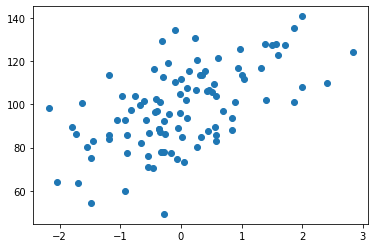

In [6]:
plt.scatter(Scale_PIN, CIQ)
plt.show()

In [7]:
#fit the univariate linear regression
with pm.Model() as Linreg:
    alpha = pm.Normal('alpha', mu=0, sd=15)#prior on alpha
    beta = pm.Normal("beta", mu=0,sd=5)#prior on beta
    sigma = pm.Uniform("sigma",0,50)#prior on sigma
    mu = alpha + beta*(Scale_PIN)
    ChildIQ = pm.Normal('ChildIQ', mu=mu, sd=sigma, observed=CIQ)#likelihood of the data
    mean_q = pm.find_MAP()
    #print(mean_q)
    Hess = pm.find_hessian(mean_q, vars=[alpha, beta,sigma])#find the hessian matrix
    sample = pm.sample(draws= 250, chains = 4)#1000 random samples on 4 chains
    #get summary reports from the MCMC
    #pm.traceplot(sample)
pm.summary(sample)

Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 2 seconds.
The acceptance probability does not match the target. It is 0.886262245856655, but should be close to 0.8. Try to increase the number of tuning steps.
/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,97.247,1.591,94.430,100.198,0.045,0.032,1269.0,1267.0,1257.0,709.0,1.01
beta,9.991,1.448,7.692,13.044,0.040,0.028,1323.0,1310.0,1316.0,762.0,1.00
sigma,15.616,1.181,13.608,17.822,0.035,0.025,1113.0,1112.0,1087.0,779.0,1.00


/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

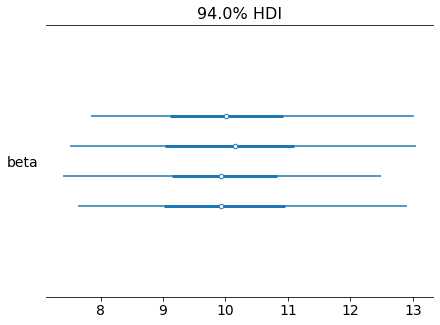

In [8]:
pm.forestplot(sample, var_names=["beta"])

We can see that there's a relatively strong association between parential income and child's IQ if we don't factor any other variables into the data. Now let's factor in both variables together

In [9]:
#running a multivariate linear regression
with pm.Model() as Linreg:
    alpha = pm.Normal('alpha', mu=0, sd=15)#prior on alpha
    beta1 = pm.Normal("beta1", mu=0,sd=5)#prior on beta1
    beta2 = pm.Normal("beta2", mu=0,sd=5)#prior on beta2
    sigma = pm.Uniform("sigma",0,50)#prior on sigma
    mu = alpha + beta1*Scale_PIN + beta2 * Scale_PIQ
    ChildIQ = pm.Normal('ChildIQ', mu=mu, sd=sigma, observed=CIQ)#likelihood of the data
    mean_q = pm.find_MAP()
    #print(mean_q)
    #Hess = pm.find_hessian(mean_q, vars=[alpha, beta,sigma])#find the hessian matrix
    sample = pm.sample(draws= 250, chains = 4)#1000 random samples on 4 chains
    #get summary reports from the MCMC
    #pm.traceplot(sample)
pm.summary(sample)

Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta2, beta1, alpha]


Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 2 seconds.
/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,97.899,0.889,96.246,99.465,0.027,0.019,1115.0,1113.0,1130.0,778.0,1.0
beta1,1.560,1.109,-0.527,3.716,0.042,0.031,698.0,647.0,682.0,734.0,1.0
beta2,15.167,1.143,13.174,17.450,0.045,0.032,637.0,637.0,643.0,522.0,1.0
sigma,8.972,0.698,7.652,10.231,0.025,0.018,794.0,794.0,766.0,688.0,1.0


/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

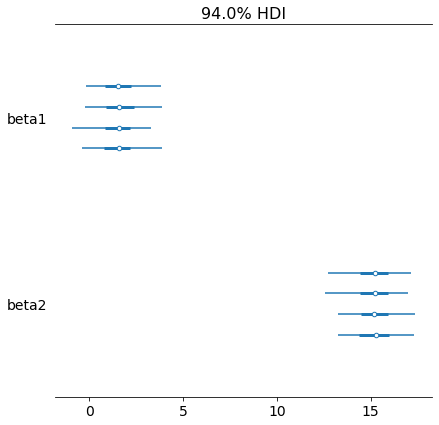

In [10]:
pm.forestplot(sample, var_names=["beta1","beta2"])

We can inspect the posterior credible intervals the 4 random samples of the posterior distribution that was run. Clear $\beta_1$ is now consistent with equalling zero, whilst $\beta_2$ does not, all reflecting the spurious nature of the associtation.

5M2. Invent your own example of a masked relationship. An outcome variable should be correlated with both predictor variables, but in opposite directions. And the two predictor variables should be correlated with one another.

Answer: I'm going to be boring on this one and just call the variables X,Y,Z. The causal diagram below shows what has a causal impact on what else. Here we will make X and Y be inversely correlated, but make X and Y both have a positive causal relationship with Z.

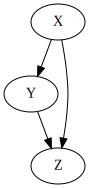

In [11]:
from causalgraphicalmodels import CausalGraphicalModel

Relation = CausalGraphicalModel(
    nodes=["X", "Y", "Z"],
    edges=[
        ("X","Y"),
        ("X", "Z"),
        ("Y","Z")
    ]
)

# draw return a graphviz `dot` object, which jupyter can render
Relation.draw()

I'll fit 2 models to investigate the effect of X on Z. The univaritae and then the multivariate.

### Model 1



$Z$ ~ $N(\mu_i,\sigma^2)$

$\mu_i = \alpha + \beta(X - \bar{X})$

$\alpha$ ~ $N(0,1)$ 

$\beta$ ~ $N(0,1)$ The relationships are presumed to have positive slopes, as seen by eyeing the scatter plots

$\sigma$ ~ $Unif(0,5)$

### Model 2

$CIQ_i$ ~ $N(\mu_i,\sigma^2)$

$\mu_i = \alpha + \beta_{X} (X - \bar{X}) + \beta_{Y}(Y - \bar{Y})  $

$\alpha$ ~ $N(1,10)$ 

$\beta_{X}$ ~ $N(0,1)$ This our priors must reflect the fact that we think the relationship could be zero or slightly negative when we factor for other variables. This we change from a log-normal to a normal prior

$\beta_{Y}$ ~ $N(0,1)$ 

$\sigma$ ~ $Unif(0,10)$


In [12]:
#simultate the data
X = np.random.normal(size=50)
Y = np.random.normal(loc=-X)
Z = np.random.normal(2*X+2*Y)

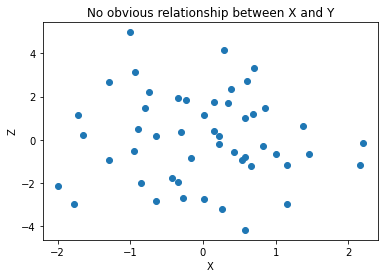

In [13]:
plt.scatter(X,Z)
plt.xlabel("X")
plt.ylabel("Z")
plt.title("No obvious relationship between X and Y")
plt.show()

In [14]:
#Fit the model
with pm.Model() as Linreg:
    alpha = pm.Normal('alpha', mu=0, sd=1)#prior on alpha
    beta = pm.Normal("beta", mu=0,sd=1)#prior on beta
    sigma = pm.Uniform("sigma",0,10)#prior on sigma
    mu = alpha + beta*(X - np.mean(X))
    Z_vals = pm.Normal('Z_vals', mu=mu, sd=sigma, observed=Z)#likelihood of the data
    mean_q = pm.find_MAP()
    #print(mean_q)
    Hess = pm.find_hessian(mean_q, vars=[alpha, beta,sigma])#find the hessian matrix
    sample = pm.sample(draws= 250, chains = 4)#1000 random samples on 4 chains
    #get summary reports from the MCMC
    #pm.traceplot(sample)
pm.summary(sample)

Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 2 seconds.
/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.057,0.286,-0.485,0.611,0.008,0.008,1403.0,691.0,1398.0,910.0,1.01
beta,-0.120,0.295,-0.654,0.411,0.009,0.008,1163.0,610.0,1171.0,838.0,1.00
sigma,2.103,0.215,1.743,2.518,0.006,0.004,1256.0,1239.0,1237.0,799.0,1.00


/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

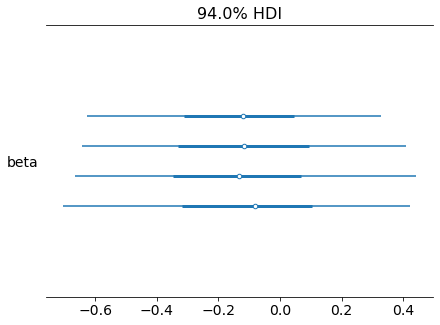

In [15]:
pm.forestplot(sample, var_names=["beta"])

Clearly this looks like the there is very little evidence for an association between X and Z, as the $\beta$ hpdi show considerable overlap with zero.

In [16]:
#Fit the multivariate model
with pm.Model() as Linreg:
    alpha = pm.Normal('alpha', mu=0, sd=1)#prior on alpha
    beta_x = pm.Normal("beta_x", mu=0,sd=1)#prior on beta_x
    beta_y = pm.Normal("beta_y", mu=0,sd=1)#prior on beta_y
    sigma = pm.Uniform("sigma",0,10)#prior on sigma
    mu = alpha + beta_x*(X - np.mean(X)) + beta_y *(Y-np.mean(Y))
    Z_vals = pm.Normal('Z_vals', mu=mu, sd=sigma, observed=Z)#likelihood of the data
    mean_q = pm.find_MAP()
    sample = pm.sample(draws= 250, chains = 4)#1000 random samples on 4 chains
    #get summary reports from the MCMC
    #pm.traceplot(sample)
pm.summary(sample)

Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_y, beta_x, alpha]


Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 2 seconds.
/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.059,0.142,-0.185,0.360,0.005,0.005,696.0,475.0,687.0,584.0,1.00
beta_x,1.783,0.218,1.334,2.146,0.010,0.007,485.0,485.0,485.0,574.0,1.00
beta_y,1.759,0.146,1.468,2.012,0.006,0.004,544.0,544.0,548.0,673.0,1.00
sigma,0.972,0.109,0.772,1.174,0.004,0.003,629.0,629.0,611.0,401.0,1.01


/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

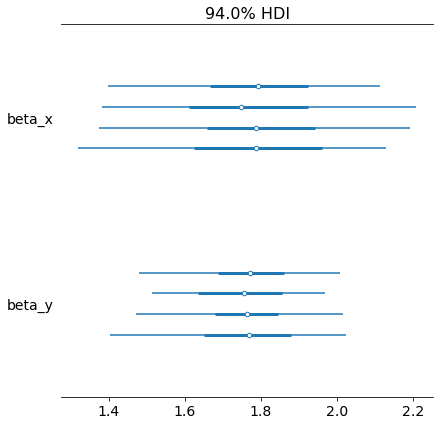

In [17]:
pm.forestplot(sample, var_names=["beta_x","beta_y"])

When both variables are factored in, there's a positve association between X and Z. Thus, performing both regressions demonstrates the relationship between the two was being masked.

5M3. It is sometimes observed that the best predictor of fire risk is the presence of firefighters States and localities with many firefighters also have more fires. Presumably firefighters do not cause
fires. Nevertheless, this is not a spurious correlation. Instead fires cause firefighters. Consider the same reversal of causal inference in the context of the divorce and marriage data. How might a high divorce rate cause a higher marriage rate? Can you think of a way to evaluate this relationship, using multiple regression?

Answer: It's plausible that high divorce rate increases the marriage rate via something like the following mechanism. High divorce rate increase the number of people who are available to get married. That is, the high marriage rate is dragged up by people being divorced. This is not immediately testable with multiple regression as that only allows one to test for the presence of a causal relation ship, but doesn't tell us which way the arrow of causality points.

5M4. In the divorce data, States with high numbers of members of the Church of Jesus Christ of Latter-day Saints (LDS) have much lower divorce rates than the regression models expected. Find a list of LDS population by State and use those numbers as a predictor variable, predicting divorce rate using marriage rate, median age at marriage, and percent LDS population (possibly standardized). You may want to consider transformations of the raw percent LDS variable.

I found LDS population data on wikipedia at https://en.wikipedia.org/wiki/The_Church_of_Jesus_Christ_of_Latter-day_Saints_membership_statistics_(United_States). Accessed on 20/09/2020.

In [18]:
data = pd.read_csv("./data/WaffleDivorce.csv",delimiter=";")

In [19]:
LDS = pd.read_csv("./data/wikipedia_lds.csv")

In [20]:
#Rename the column names to make data sets cohere
col_names = LDS.columns.values
col_names[0] = "Location"
LDS.columns = col_names

In [21]:
data.shape, pop.shape

NameError: name 'pop' is not defined

In [ ]:
data.head(5)
pop.head(5)

In [22]:
#combine data and retain only the states that are in both data sets
combined = pd.merge(data,LDS, on=["Location"])

In [23]:
combined.head(5)

,Location,Loc,Population_x,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,...,Population_y,LDS,Temples,Missions,Districts,Stakes,Wards,Branches,Congregations,Family History Centers
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,...,"4,903,185",0.77%,1,1,0,8,48,28,76,44
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,...,"731,545",4.58%,1,1,0,8,59,21,80,15
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,...,"7,278,717",6.00%,6,6,0,115,842,84,926,74
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,...,"3,017,804",1.07%,0,2,0,7,46,23,69,25
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,...,"39,512,223",1.91%,7,15,0,153,"1,092",137,"1,229",228


We can now attempt to factor the LDS data as an additional predictor variable of divorce rate using the following model:

$CIQ_i$ ~ $N(\mu_i,\sigma^2)$

$\mu_i = \alpha + \beta_{M}M_i + \beta_{A}A_i + \beta_L L_i  $

$\alpha$ ~ $N(0,0.2)$ 

$\beta_{M}$ ~ $N(0,0.5)$ 

$\beta_{A}$ ~ $N(0,0.5)$

$\beta_{L}$ ~ $N(0,0.5)$

$\sigma$ ~ $Exp(1)$



In [24]:
scaled_age = (combined.MedianAgeMarriage.values - np.mean(combined.MedianAgeMarriage))/np.std(combined.MedianAgeMarriage)
scaled_marriage = (combined.Marriage.values - np.mean(combined.Marriage))/np.std(combined.Marriage)

In [25]:
combined.LDS.values

array(['0.77%', '4.58%', '6.00%', '1.07%', '1.91%', '2.61%', '0.45%',
       '0.58%', '0.45%', '0.75%', '0.82%', '5.30%', '25.86%', '0.45%',
       '0.68%', '0.90%', '1.32%', '0.80%', '0.64%', '0.82%', '0.72%',
       '0.41%', '0.45%', '0.59%', '0.73%', '1.18%', '4.73%', '1.30%',
       '0.65%', '0.38%', '3.31%', '0.43%', '0.85%', '1.52%', '0.54%',
       '1.24%', '3.64%', '0.41%', '0.40%', '0.80%', '1.20%', '0.77%',
       '1.25%', '66.32%', '0.74%', '1.13%', '3.80%', '0.96%', '0.47%',
       '11.70%'], dtype=object)

In [26]:
LDS = np.array([float(word[:-1]) for word in combined.LDS.values])

In [27]:
scaled_LDS = (LDS-np.mean(LDS))/np.std(LDS)

In [28]:
#Fit the multivariate model
with pm.Model() as Linreg:
    alpha = pm.Normal('alpha', mu=0, sd=1)#prior on alpha
    beta_M = pm.Normal("beta_M", mu=0,sd=0.5)#prior on beta_M
    beta_A = pm.Normal("beta_A", mu=0,sd=0.5)#prior on beta_A
    beta_L = pm.Normal("beta_L", mu=0,sd=0.5)#prior on beta_L
    sigma = pm.Exponential("sigma",lam=1)#prior on sigma
    mu = alpha + beta_M*scaled_marriage + beta_A * scaled_age + beta_L * scaled_LDS
    divorce = pm.Normal('divorce', mu=mu, sd=sigma, observed=combined.Divorce)#likelihood of the data
    sample = pm.sample(draws= 1000, chains = 4)#1000 random samples on 4 chains
    #get summary reports from the MCMC
    #pm.traceplot(sample)
pm.summary(sample)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_L, beta_A, beta_M, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,9.269,0.238,8.830,9.700,0.004,0.003,3203.0,3203.0,3596.0,2193.0,1.0
beta_M,0.159,0.261,-0.370,0.619,0.005,0.004,2602.0,2480.0,2589.0,2773.0,1.0
beta_A,-0.999,0.257,-1.478,-0.507,0.005,0.004,2541.0,2541.0,2545.0,2713.0,1.0
beta_L,-0.446,0.222,-0.866,-0.026,0.004,0.003,2741.0,2559.0,2750.0,2516.0,1.0
sigma,1.497,0.179,1.202,1.855,0.003,0.002,2675.0,2627.0,2752.0,2805.0,1.0


/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

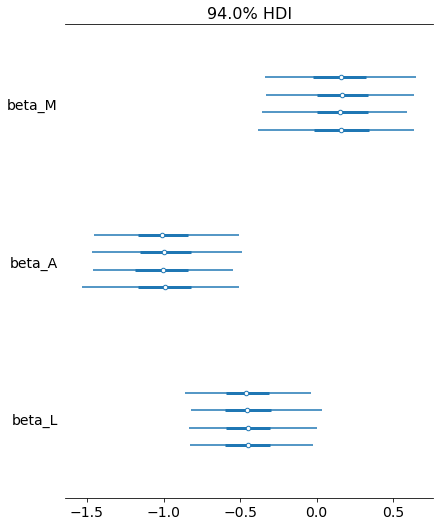

In [29]:
pm.forestplot(sample, var_names=["beta_M","beta_A","beta_L"])

This corroborates the claim the states with higher LDS proportions have lower divorce rates. The HPDI for $\beta_l$ lies below and excludes the null value from being plausable when considering all of these factors.

5M5. One way to reason through multiple causation hypotheses is to imagine detailed mechanisms through which predictor variables may influence outcomes. For example, it is sometimes argued that the price of gasoline (predictor variable) is positively associated with lower obesity rates (outcome
variable). However, there are at least two important mechanisms by which the price of gas could reduce obesity. First, it could lead to less driving and therefore more exercise. Second, it could lead to less driving, which leads to less eating out, which leads to less consumption of huge restaurant meals.
Can you outline one or more multiple regressions that address these two mechanisms? Assume you can have any predictor data you need.

We can can define the following random variables
GP: Gas price

DR: Driving rate

E: Amount of exersice 

O: Obesity Rate

EO: Eating out

The two mechanisms posed in the question can be represented through the following DAGs

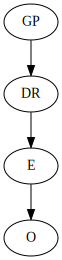

In [30]:
from causalgraphicalmodels import CausalGraphicalModel

Mechanism1 = CausalGraphicalModel(
    nodes=["GP", "DR", "E", "O"],
    edges=[
        ("GP","DR"),
        ("DR", "E"),
        ("E","O")
    ]
)

# draw return a graphviz `dot` object, which jupyter can render
Mechanism1.draw()

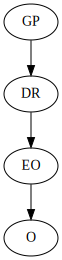

In [172]:
from causalgraphicalmodels import CausalGraphicalModel

Mechanism2 = CausalGraphicalModel(
    nodes=["GP", "DR", "EO", "O"],
    edges=[
        ("GP","DR"),
        ("DR", "EO"),
        ("EO","O")
    ]
)

# draw return a graphviz `dot` object, which jupyter can render
Mechanism2.draw()

5H1. In the divorce example, suppose the DAG is: M → A → D. What are the implied conditional independencies of the graph? Are the data consistent with it?

Answer: Given A, D is independent of M. That is because M's impact on D is mediated through A in this model, and holding A constant should mean M has no impact on D.


In [32]:
#Fit the multivariate model
with pm.Model() as Linreg:
    alpha = pm.Normal('alpha', mu=0, sd=1)#prior on alpha
    beta_M = pm.Normal("beta_M", mu=0,sd=0.5)#prior on beta_M
    beta_A = pm.Normal("beta_A", mu=0,sd=0.5)#prior on beta_A
    sigma = pm.Exponential("sigma",lam=1)#prior on sigma
    mu = alpha + beta_M*scaled_marriage + beta_A * scaled_age
    divorce = pm.Normal('divorce', mu=mu, sd=sigma, observed=data.Divorce)#likelihood of the data
    sample = pm.sample(draws= 1000, chains = 4)#1000 random samples on 4 chains
    #get summary reports from the MCMC
    #pm.traceplot(sample)
pm.summary(sample)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_A, beta_M, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,9.218,0.246,8.785,9.701,0.005,0.003,2910.0,2910.0,3003.0,2456.0,1.0
beta_M,0.042,0.252,-0.407,0.544,0.005,0.004,2340.0,2340.0,2351.0,2775.0,1.0
beta_A,-0.867,0.261,-1.344,-0.371,0.006,0.004,2019.0,2019.0,2052.0,2778.0,1.0
sigma,1.590,0.183,1.264,1.919,0.004,0.003,2312.0,2217.0,2486.0,2284.0,1.0


/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

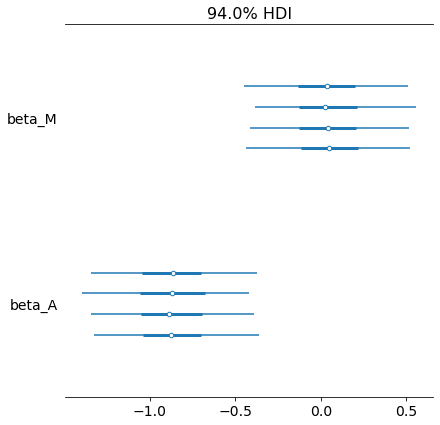

In [33]:
pm.forestplot(sample, var_names=["beta_M","beta_A"])

As can be seen, this is consistent with M being conditionally independent of D, as the posterior value on the strength of the association is very consistent with there being no association between M when A is factored in.

5H2. Assuming that the DAG for the divorce example is indeed M → A → D, fit a new model and use it to estimate the counterfactual effect of halving a State’s marriage rate M. Use the counterfactual example from the chapter (starting on page 140) as a template.

In order to produce the counter factual plots, one needs to measure the strength of all the associations as implied by the model. We need to find the strength of the dependencies between M and A, then the strength of the association beween A and D. Then we can modify the value of M and see how this propagates through the DAG. I'll be using the quadratic approximation to obtain the predictive plots.

In [34]:
#Fit model1 M-> A
with pm.Model() as Linreg1:
    alpha = pm.Normal('alpha', mu=0, sd=1)#prior on alpha
    beta_M = pm.Normal("beta_M", mu=0,sd=0.5)#prior on beta_M
    sigma = pm.Exponential("sigma",lam=1)#prior on sigma
    mu = alpha + beta_M*scaled_marriage
    Age = pm.Normal('age', mu=mu, sd=sigma, observed=scaled_age)#likelihood of the data
    model1_post = pm.sample(draws= 100, chains = 4)#100 random samples on 4 chains
    #get summary reports from the MCMC
    #pm.traceplot(sample)
pm.summary(model1_post)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_M, alpha]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 2 seconds.
/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.000,0.109,-0.221,0.190,0.005,0.005,580.0,230.0,572.0,290.0,1.00
beta_M,-0.696,0.106,-0.893,-0.509,0.004,0.003,603.0,555.0,607.0,296.0,1.02
sigma,0.724,0.076,0.590,0.873,0.004,0.003,429.0,409.0,460.0,312.0,1.01


In [35]:
#Fit model2 A -> D
with pm.Model() as Linreg1:
    alpha = pm.Normal('alpha', mu=0, sd=1)#prior on alpha
    beta_A = pm.Normal("beta_A", mu=0,sd=0.5)#prior on beta_M
    sigma = pm.Exponential("sigma",lam=1)#prior on sigma
    mu = alpha + beta_A*scaled_age
    divorce = pm.Normal('divorce', mu=mu, sd=sigma, observed=data.Divorce)#likelihood of the data
    model2_post = pm.sample(draws= 100, chains = 4)#100 random samples on 4 chains
    #get summary reports from the MCMC
    #pm.traceplot(sample)
pm.summary(model2_post)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_A, alpha]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 2 seconds.
The acceptance probability does not match the target. It is 0.8835181298595873, but should be close to 0.8. Try to increase the number of tuning steps.
/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,9.198,0.255,8.747,9.720,0.014,0.010,319.0,319.0,346.0,267.0,1.01
beta_A,-0.897,0.211,-1.283,-0.512,0.010,0.007,417.0,399.0,403.0,304.0,1.00
sigma,1.593,0.190,1.273,1.921,0.011,0.008,305.0,287.0,330.0,290.0,1.01


We now have the posterior distributions for the two relationships in the causal model. We can now start to investigate the impact of interventions under this causal model. Namely, if we set the marriage rate at a certain level in a given state how would this alter the divorce rate, when divorce rate is mediated through age.

In [36]:
#Find a suitable range
np.min(scaled_marriage), np.max(scaled_marriage)

(-1.7591667404919278, 2.815624299190736)

In [ ]:
y = np.outer(MR,model1_post["beta_M"]) +  model1_post["alpha"]

In [ ]:
1.15759881 + model1_post["alpha"][0]

In [ ]:
model1_post["alpha"][0]

In [46]:
#range from 12 to 32
MR = np.linspace(-2,3) #marriage rate
#get the predicted marriages ages
MA= np.outer(MR,model1_post["beta_M"]) +  model1_post["alpha"]#each row is intervention variable
Predictions = np.array([ np.array(np.outer(MA[row,:],model2_post["beta_A"]) +  model2_post["alpha"]).ravel() for row in range(MA.shape[0])])

In [51]:
mean_pred = np.mean(Predictions,axis = 1)
low_pred = np.quantile(Predictions, 0.055,axis =1)
upper_pred = np.quantile(Predictions, 0.945,axis =1)

In [56]:
unscaled_MR = MR*np.std(data.Marriage) + np.mean(data.Marriage)

Text(0.5, 1.0, 'Counter Factual plot of MR on DR')

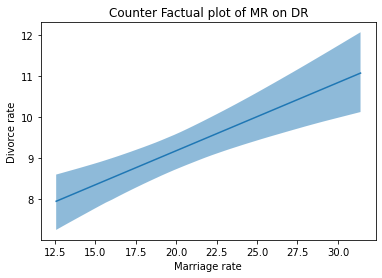

In [59]:
plt.plot(unscaled_MR, mean_pred)
plt.fill_between(unscaled_MR, y1=low_pred,y2=upper_pred, alpha=0.5)
plt.xlabel("Marriage rate")
plt.ylabel("Divorce rate")
plt.title("Counter Factual plot of MR on DR")

5H3. Return to the milk energy model, m5.7. Suppose that the true causal relationship among the variables is: (see below)


Now compute the counterfactual effect on K of doubling M. You will need to account for both the
direct and indirect paths of causation. Use the counterfactual example from the chapter (starting on page 140) as a template

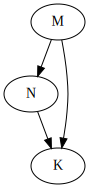

In [61]:
h3 = CausalGraphicalModel(
    nodes=["M", "N", "K"],
    edges=[
        ("M","N"),
        ("M", "K"),
        ("N","K")
    ]
)

# draw return a graphviz `dot` object, which jupyter can render
h3.draw()

In [64]:
milk = pd.read_csv("./data/milk.csv", delimiter=";")

2 models needed here. The effect of M on N. Then the joint effect of N and M on K is also needed. I'll run 3 MCMC models on the data.

In [67]:
milk = milk[~np.isnan(milk["neocortex.perc"])] #perform complete case analysis
scale_M = (milk["mass"] - np.mean(milk["mass"]))/np.std(milk["mass"])
scale_N = (milk["neocortex.perc"] - np.mean(milk["neocortex.perc"]))/np.std(milk["neocortex.perc"])


In [232]:
#Fit model1 M-> N
with pm.Model() as Linreg1:
    alpha = pm.Normal('alpha', mu=0, sd=1)#prior on alpha
    beta_M = pm.Normal("beta_M", mu=0,sd=0.5)#prior on beta_M
    sigma = pm.Exponential("sigma",lam=1)#prior on sigma
    mu = alpha + beta_M*scale_M
    neo = pm.Normal('neo', mu=mu, sd=sigma, observed=scale_N)#likelihood of the data
    model1_post = pm.sample(draws= 500, chains = 4)#100 random samples on 4 chains
    #get summary reports from the MCMC
    #pm.traceplot(sample)
pm.summary(model1_post)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_M, alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 2 seconds.
/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-0.002,0.214,-0.410,0.402,0.005,0.005,1973.0,1008.0,2000.0,1242.0,1.0
beta_M,0.514,0.199,0.112,0.884,0.005,0.003,1872.0,1872.0,1907.0,1376.0,1.0
sigma,0.885,0.181,0.603,1.218,0.005,0.003,1529.0,1437.0,1642.0,1195.0,1.0


In [233]:
#Fit model2 A -> D
with pm.Model() as Linreg1:
    alpha = pm.Normal('alpha', mu=0, sd=1)#prior on alpha
    beta_M = pm.Normal("beta_M", mu=0,sd=0.5)#prior on beta_M
    beta_N = pm.Normal("beta_N", mu=0,sd=0.5)#prior on beta_N
    sigma = pm.Exponential("sigma",lam=1)#prior on sigma
    mu = alpha + beta_M*scale_M + beta_N * scale_N
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=milk["kcal.per.g"])#likelihood of the data
    model2_post = pm.sample(draws= 500, chains = 4)#1000 random samples on 4 chains
    #get summary reports from the MCMC
    #pm.traceplot(sample)
pm.summary(model2_post)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_N, beta_M, alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 2 seconds.
/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.658,0.040,0.586,0.737,0.001,0.001,1343.0,1328.0,1382.0,1034.0,1.00
beta_M,-0.121,0.050,-0.210,-0.024,0.001,0.001,1170.0,1132.0,1183.0,1071.0,1.00
beta_N,0.100,0.048,0.010,0.187,0.001,0.001,1066.0,1066.0,1070.0,1115.0,1.00
sigma,0.161,0.034,0.108,0.224,0.001,0.001,1052.0,1031.0,1080.0,1039.0,1.01


/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

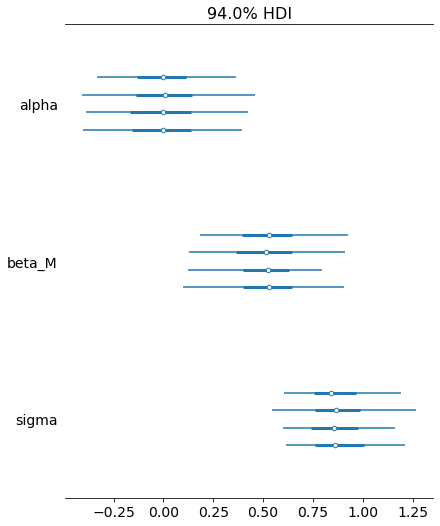

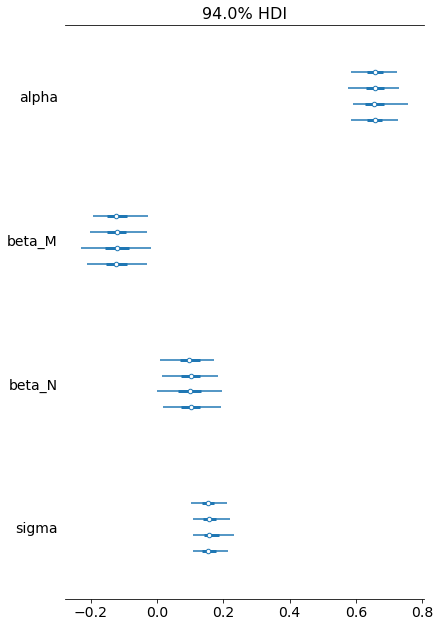

In [234]:
pm.forestplot(model1_post)#model 1 interval
pm.forestplot(model2_post)#model 2 intervals

We now compute the counterfactual plots as follow:

In [235]:
#find a sensible range of prediction values
np.min(scale_M), np.max(scale_M)

(-0.7219815310503496, 2.7446354164897317)

In [236]:
def N_func(M): return model1_post["alpha"] + M * model1_post["beta_M"]
def K_func(M,N): return model2_post["alpha"] + M * model2_post["beta_M"] + np.multiply(N,model2_post["beta_N"])

In [237]:
K = np.array([K_func(M,N_func(M)) for M in np.linspace(-1,3)])

In [238]:
#get unscaled Marriage coords
Mass = np.linspace(-1,3)*np.std(milk["mass"]) + np.mean(milk["mass"])

Text(0.5, 1.0, 'Counterfactual of M for K')

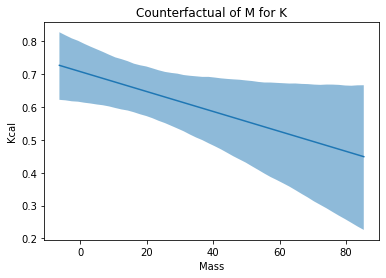

In [239]:
plt.plot(Mass, np.mean(K,axis=1))
plt.fill_between(Mass, np.quantile(K,0.055,axis=1),np.quantile(K,0.945,axis=1),alpha = 0.5)
plt.xlabel("Mass")
plt.ylabel("Kcal")
plt.title("Counterfactual of M for K")